In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import glob
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman as nemenyi
from quality.create_quality_df import create_pred_df, calculate_measures
import sys
sys.path.append("/home/dobraczka/Downloads/git/CSVtoLaTeXTable/colorizelatextables")
from colorize_table import to_colorized_latex, add_avg_rank

In [2]:
def get_new_values(basepath=None):
    datasets = ["D_W_15K_V1",
            "D_W_15K_V2",
            "D_Y_15K_V1",
            "D_Y_15K_V2",
            "EN_DE_15K_V1",
            "EN_DE_15K_V2",
            "EN_FR_15K_V1",
            "EN_FR_15K_V2",
            "D_W_100K_V1",
            "D_W_100K_V2",
            "D_Y_100K_V1",
            "D_Y_100K_V2",
            "EN_DE_100K_V1",
            "EN_DE_100K_V2",
            "EN_FR_100K_V1",
            "EN_FR_100K_V2",
            "abt-buy",
            "amazon-google",
            "dblp-scholar",
            "dblp-acm",
            "imdb-tmdb",
            "tmdb-tvdb",
            "imdb-tvdb"]
    app = ["boot_ea","rdgcn","multi_ke"]
    approaches = ["BootEA","RDGCN","MultiKE"]
    frames = []
    for ds_name in datasets:
        for fold in range(1,6):
            for embed_approach,embed in zip(approaches,app):
                try:
                    if basepath==None:
                        file_path = glob.glob(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/results*/output/results/{ds_name}-721_5fold-{fold}/{embed_approach}/datasets/*/*{embed}.csv")[0]
                    else:
                        file_path = glob.glob(basepath + f"/output/results/{ds_name}-721_5fold-{fold}/{embed_approach}/datasets/*/*{embed}.csv")[0]
                except IndexError:
                    print(f"{ds_name} {fold} {embed_approach} {embed}")
                df = pd.read_csv(file_path)
                df["embed_model"] = embed_approach
                df["fold"] = fold
                df["dataset"] = ds_name
                frames.append(df)
    return pd.concat(frames)

In [3]:
df = get_new_values()
df["model_name"] = df["model_name"].map({"ada boost":"Ada","decision tree":"DT","gaussian naive bayes":"Bayes","random forest 500":"RF","svc":"svc","MLP":"MLP","logistic regression":"lr"})
rich_graph_datasets ={
        "D_W_15K_V1",
    "D_W_15K_V2",
    "D_Y_15K_V1",
    "D_Y_15K_V2",
    "EN_DE_15K_V1",
    "EN_DE_15K_V2",
    "EN_FR_15K_V1",
    "EN_FR_15K_V2",
    "D_W_100K_V1",
    "D_W_100K_V2",
    "D_Y_100K_V1",
    "D_Y_100K_V2",
    "EN_DE_100K_V1",
    "EN_DE_100K_V2",
    "EN_FR_100K_V1",
    "EN_FR_100K_V2",
}
only_sim = df[df["vector_name"]=="OnlySim"].groupby(["model_name","dataset","fold"]).mean().reset_index()
only_sim["vector_name"] = "OnlySim"
only_sim["embed_model"] = ""
df = df[df["vector_name"]!="OnlySim"]
df = pd.concat([df,only_sim])
allowed_models={"MLP","RF"}
allowed_vectors={"OnlySim","OnlyEmb","SimAndEmb"}
df = df[df["model_name"].isin(allowed_models)]
df = df[df["vector_name"].isin(allowed_vectors)]
df.rename(columns= {"test_f1":"fm","test_precision":"prec","test_recall":"rec"},inplace=True)
df = df[["model_name","vector_name","dataset","embed_model","fm","prec","rec","fold"]]
rich_df = df[df["dataset"].isin(rich_graph_datasets)]
rich_df["ds_size"] = rich_df["dataset"].map(lambda x: x.split("_")[2])
rich_df["dataset"] = rich_df["dataset"].map(lambda x: x.replace("15K","").replace("100K","").replace("_","-").replace("--V1","(V1)").replace("--V2","(V2)"))
r_small = rich_df[rich_df["ds_size"]=="15K"]
r_large = rich_df[rich_df["ds_size"]=="100K"]
shallow_df = df[~df["dataset"].isin(rich_graph_datasets)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
sns.set(font_scale=2) 
sns.set_style("ticks")
sns.despine(left=True)
mag15 = pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/OpenEA15K-magellan_results.csv")
#mag15 = mag15.groupby(["model_name","dataset"]).mean().reset_index()
mag100 = pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/OpenEA100K-magellan_results.csv")
#mag100 = mag100.groupby(["model_name","dataset"]).mean().reset_index()
dm = pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/results/deepmatcher_results.csv")
#dm = dm.groupby(["model_name","dataset"]).mean().reset_index()
dm["fm"] = dm["fm"]/100
dm["prec"] = dm["prec"]/100
dm["rec"] = dm["rec"]/100


dm["framework"] ="DeepMatcher"
dm["embed_model"] = ""
dm["vector_name"] = ""
dm["model_name"] = ""

s = df[df["dataset"].str.contains("K")]


#.groupby(["embed_model","vector_name","model_name","dataset"]).mean().reset_index()
s = s[s["model_name"].isin(["MLP","RF"])]
s = s[(s["vector_name"]=="SimAndEmb")&(s["embed_model"]=="MultiKE")]
mag = pd.concat([mag15,mag100])
mag["framework"] ="Magellan"
mag["embed_model"] = ""
mag["vector_name"] = ""
mag["model_name"] = mag["model_name"].map(lambda x: x.replace("rf","RF"))
s["framework"] = "EAGER"
c = pd.concat([s,dm,mag])
c["ds_size"] = c["dataset"].map(lambda x: x.split("_")[2])
c["dataset"] = c["dataset"].map(lambda x: x.replace("15K","").replace("100K","").replace("_","-").replace("--V1","(V1)").replace("--V2","(V2)"))
c["framework"] = c["framework"].map(str) + c["model_name"].map(lambda x : " " + x if len(x) > 1 else "")
#c = c.melt(id_vars=["dataset","model_name","framework"],value_vars=["fm","prec","rec"],var_name="metric")
r_small = c[c["ds_size"]=="15K"].melt(id_vars=["dataset","model_name","framework"],value_vars=["fm","prec","rec"],var_name="metric")
r_large = c[c["ds_size"]=="100K"].melt(id_vars=["dataset","model_name","framework"],value_vars=["fm","prec","rec"],var_name="metric")

<Figure size 432x288 with 0 Axes>

In [5]:
df = pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/magellan_resultsFinal.csv")
df = pd.concat([df[df["dataset"]!="amazon-google"],pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/amazon-google-magellan_results.csv")])
magellan = df
magellan["framework"] = "Magellan"
dm_files = ["abt-buy_deepmatcher_results.csv", "dblp-scholar_deepmatcher_results.csv", "tmdb-tvdb_deepmatcher_results.csv", "amazon-google_deepmatcher_results.csv", "imdb-tmdb_deepmatcher_results.csv", "dblp-acm_deepmatcher_results.csv", "imdb-tvdb_deepmatcher_results.csv"]
dm_frames = []
for f in dm_files:
    dm_frames.append(pd.read_csv("/home/dobraczka/Downloads/git/EmbeddingBenchmarkMagellan/results/" + f))
dm = pd.concat(dm_frames).rename(columns={"model_name":"framework"}).drop("time",axis=1)
dm["fm"] = dm["fm"]/100
dm["rec"] = dm["rec"]/100
dm["prec"] = dm["prec"]/100
dm["model_name"] = ""
shallow_df["framework"] = "EAGER"
all_shallow = pd.concat([dm,magellan,shallow_df[(shallow_df["vector_name"]=="SimAndEmb") & (shallow_df["embed_model"]=="MultiKE")]]).drop(["embed_model","vector_name"],axis=1)
all_shallow["model_name"] = all_shallow["model_name"].map(lambda x: x.replace("rf","RF"))
all_shallow["framework"] = all_shallow["framework"].map(str) + all_shallow["model_name"].map(lambda x : " " + x if len(x) > 1 else "")
all_shallow = all_shallow[all_shallow["model_name"].isin(["RF","MLP","XGBoost",""])]
a_s = all_shallow.melt(id_vars=["dataset","framework"],value_vars=["fm","prec","rec"],var_name='metric', value_name='value')

In [6]:
a_s

,dataset,framework,metric,value
0,abt-buy,DeepMatcher,fm,0.939789
1,abt-buy,DeepMatcher,fm,0.894706
2,abt-buy,DeepMatcher,fm,0.916310
3,abt-buy,DeepMatcher,fm,0.953518
4,abt-buy,DeepMatcher,fm,0.944762
...,...,...,...,...
700,imdb-tvdb,EAGER RF,rec,0.996124
701,imdb-tvdb,EAGER MLP,rec,0.996124
702,imdb-tvdb,EAGER RF,rec,0.994832
703,imdb-tvdb,EAGER MLP,rec,1.000000


In [7]:
piv_rich = c.melt(id_vars=["ds_size","dataset","model_name","framework"],value_vars=["fm","prec","rec"],var_name="metric").pivot_table(index=["ds_size","dataset"],columns=["framework","model_name","metric"],values=["value"],aggfunc="first")
piv_shallow = a_s.pivot_table(index=["dataset"],columns=["framework","metric"],values=["value"],aggfunc="first")

In [8]:
cols = ["EAGER MLP","EAGER RF","DeepMatcher","Magellan XGBoost","Magellan RF"]
rich_table = piv_rich["value"].loc[:,piv_rich["value"].columns.get_level_values(0).isin(cols)]
new_cols = rich_table.columns.reindex(cols, level = 0)
rich_table = rich_table.reindex(columns= new_cols[0])

In [9]:
shallow_table = piv_shallow["value"].loc[:,piv_shallow["value"].columns.get_level_values(0).isin(cols)]
new_shallow_cols = shallow_table.columns.reindex(cols, level = 0)
shallow_table = shallow_table.reindex(columns= new_shallow_cols[0])
shallow_table

framework     EAGER MLP                      EAGER RF                      \
metric               fm      prec       rec        fm      prec       rec   
dataset                                                                     
abt-buy        0.975196  0.976471  0.973924  0.975896  0.975260  0.976532   
amazon-google  0.976071  0.988726  0.963736  0.974725  0.974725  0.974725   
dblp-acm       0.997748  0.998712  0.996787  0.998715  0.998715  0.998715   
dblp-scholar   0.995985  0.997587  0.994388  0.997592  0.998661  0.996526   
imdb-tmdb      0.995630  0.998539  0.992738  0.993068  0.997801  0.988381   
imdb-tvdb      0.994805  1.000000  0.989664  0.994160  0.998696  0.989664   
tmdb-tvdb      0.996797  1.000000  0.993614  0.998081  1.000000  0.996169   

framework     DeepMatcher                     Magellan XGBoost            \
metric                 fm      prec       rec               fm      prec   
dataset                                                                    
abt-buy          0.939789  0.896919  0.986962         0.975357  0.970323   
amazon-google    0.725187  0.663927  0.798901         0.723380  0.764059   
dblp-acm         0.984187  0.968867  1.000000         0.998069  0.999356   
dblp-scholar     0.997596  0.997064  0.998129         0.997464  0.996532   
imdb-tmdb        0.982894  0.969761  0.996387         0.996379  0.998549   
imdb-tvdb        0.989180  0.980802  0.997702         0.991105  0.990252   
tmdb-tvdb        0.986614  0.976875  0.996548         0.992529  0.991389   

framework               Magellan RF                      
metric              rec          fm      prec       rec  
dataset                                                  
abt-buy        0.980443    0.979221  0.975420  0.983051  
amazon-google  0.686813    0.723558  0.798408  0.661538  
dblp-acm       0.996787    0.998391  1.000000  0.996787  
dblp-scholar   0.998397    0.997862  0.997862  0.997862  
imdb-tmdb      0.994220    0.997470  0.997831  0.997110  
imdb-tvdb      0.991959    0.991698  0.988584  0.994831  
tmdb-tvdb      0.993671    0.995119  0.993123  0.997123

In [10]:
latex_string, defined = to_colorized_latex(rich_table,colors_rgb=sns.color_palette("Blues_r",n_colors=1),avg_rank_colors_rgb=sns.color_palette("Purples_r",n_colors=3),level=2,level_value="fm",float_format="{:0.3f}".format,multirow=True)
print(latex_string)
print("\n".join(defined))

\begin{tabular}{lllrrlrrlrrlrrlrr}
\toprule
    & framework & \multicolumn{3}{l}{EAGER MLP} & \multicolumn{3}{l}{EAGER RF} & \multicolumn{3}{l}{DeepMatcher} & \multicolumn{3}{l}{Magellan XGBoost} & \multicolumn{3}{l}{Magellan RF} \\
    & model\_name & \multicolumn{3}{l}{MLP} & \multicolumn{6}{l}{RF} & \multicolumn{3}{l}{XGBoost} & \multicolumn{3}{l}{RF} \\
    & metric &                         fm &   prec &    rec &                         fm &   prec &    rec &                         fm &   prec &    rec &               fm &   prec &    rec &          fm &   prec &    rec \\
ds\_size & dataset &                            &        &        &                            &        &        &                            &        &        &                  &        &        &             &        &        \\
\midrule
\multirow{8}{*}{100K} & D-W(V1) &                      0.844 &  0.993 &  0.733 &                      0.993 &  0.989 &  0.726 &  {\cellcolor{rankcolor1}}0.733 &  0.907 &  0.

In [11]:
latex_string, defined = to_colorized_latex(shallow_table,colors_rgb=sns.color_palette("Blues_r",n_colors=1),avg_rank_colors_rgb=sns.color_palette("Purples_r",n_colors=3),level=1,level_value="fm",float_format="{:0.3f}".format,
                                           column_format="|c|ccc|ccc|ccc|ccc|ccc|",multirow=True)
print(latex_string)
print("\n".join(defined))

\begin{tabular}{|c|ccc|ccc|ccc|ccc|ccc|}
\toprule
framework & \multicolumn{3}{l}{EAGER MLP} & \multicolumn{3}{l}{EAGER RF} & \multicolumn{3}{l}{DeepMatcher} & \multicolumn{3}{l}{Magellan XGBoost} & \multicolumn{3}{l}{Magellan RF} \\
metric &                         fm &   prec &    rec &                         fm &   prec &    rec &                         fm &   prec &    rec &               fm &   prec &    rec &                         fm &   prec &    rec \\
dataset       &                            &        &        &                            &        &        &                            &        &        &                  &        &        &                            &        &        \\
\midrule
abt-buy       &                      0.975 &  0.976 &  0.974 &                      0.976 &  0.975 &  0.977 &                      0.974 &  0.897 &  0.987 &            0.976 &  0.970 &  0.980 &  {\cellcolor{rankcolor1}}0.975 &  0.975 &  0.983 \\
amazon-google &  {\cellcolor{rankco

In [12]:
new_df = get_new_values("/home/dobraczka/Downloads/git/er-embedding-benchmark/data/all_concat_results2021-01-13")
new_df["model_name"] = new_df["model_name"].str.replace(r'\s\-\s.*','')
new_df["model_name"] = new_df["model_name"].map({"ada boost":"Ada","decision tree":"DT","gaussian naive bayes":"Bayes","random forest 500":"RF","svc":"svc","MLP":"MLP","logistic regression":"lr"})
new_allowed_models={"MLP","RF"}
new_allowed_vectors={"AllConcatAndEmb","OnlyAllConcat"}
new_df = new_df[new_df["model_name"].isin(new_allowed_models)]
new_df = new_df[new_df["vector_name"].isin(new_allowed_vectors)]
new_df.rename(columns= {"test_f1":"fm","test_precision":"prec","test_recall":"rec"},inplace=True)
new_df = new_df[["model_name","vector_name","dataset","embed_model","fm","prec","rec","fold"]]
new_rich_df = new_df[new_df["dataset"].isin(rich_graph_datasets)]
new_rich_df["ds_size"] = new_rich_df["dataset"].map(lambda x: x.split("_")[2])
new_rich_df["dataset"] = new_rich_df["dataset"].map(lambda x: x.replace("15K","").replace("100K","").replace("_","-").replace("--V1","(V1)").replace("--V2","(V2)"))
new_r_small = new_rich_df[new_rich_df["ds_size"]=="15K"]
new_r_large = new_rich_df[new_rich_df["ds_size"]=="100K"]
new_shallow_df = new_df[~new_df["dataset"].isin(rich_graph_datasets)]

EN_DE_100K_V2 4 RDGCN rdgcn
EN_FR_100K_V1 4 RDGCN rdgcn


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [13]:
new_rich_df[new_rich_df["vector_name"]=="AllConcatAndEmb"]

,model_name,vector_name,dataset,embed_model,fm,prec,rec,fold,ds_size
6,MLP,AllConcatAndEmb,D-W(V1),BootEA,0.788120,0.998977,0.650762,1,15K
26,RF,AllConcatAndEmb,D-W(V1),BootEA,0.669201,0.999243,0.503048,1,15K
3,MLP,AllConcatAndEmb,D-W(V1),RDGCN,0.795745,0.965489,0.676762,1,15K
14,RF,AllConcatAndEmb,D-W(V1),RDGCN,0.840419,0.991073,0.729524,1,15K
10,MLP,AllConcatAndEmb,D-W(V1),MultiKE,0.898451,0.988790,0.823238,1,15K
...,...,...,...,...,...,...,...,...,...
1,MLP,AllConcatAndEmb,EN-FR(V2),BootEA,0.975948,0.999730,0.953271,5,100K
5,MLP,AllConcatAndEmb,EN-FR(V2),RDGCN,0.932992,0.996768,0.876886,5,100K
52,RF,AllConcatAndEmb,EN-FR(V2),RDGCN,0.940307,0.998331,0.888657,5,100K
0,RF,AllConcatAndEmb,EN-FR(V2),MultiKE,0.979427,0.991697,0.967457,5,100K


In [14]:
#all below is modified autorank
def get_sorted_rank_groups(result, reverse):
    if reverse:
        names = result.rankdf.iloc[::-1].index.to_list()
        if result.cd is not None:
            sorted_ranks = result.rankdf.iloc[::-1].meanrank
            critical_difference = result.cd
        else:
            sorted_ranks = result.rankdf.iloc[::-1]['mean']
            critical_difference = (result.rankdf.ci_upper[0] - result.rankdf.ci_lower[0]) / 2
    else:
        names = result.rankdf.index.to_list()
        if result.cd is not None:
            sorted_ranks = result.rankdf.meanrank
            critical_difference = result.cd
        else:
            sorted_ranks = result.rankdf['mean']
            critical_difference = (result.rankdf.ci_upper[0] - result.rankdf.ci_lower[0]) / 2

    groups = []
    cur_max_j = -1
    for i in range(len(sorted_ranks)):
        max_j = None
        for j in range(i + 1, len(sorted_ranks)):
            if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
                max_j = j
                # print(i, j)
        if max_j is not None and max_j > cur_max_j:
            cur_max_j = max_j
            groups.append((i, max_j))
    return sorted_ranks, names, groups


def fix_notation(name):
    if len(name) ==2:
        vector, classifier = name
        if "SimAndEmb" in vector:
            return r'$A\mathbin\Vert E$, ' + classifier
        if "OnlyEmb" in vector:
            return r'$E$, ' + classifier
        if "OnlySim" in vector:
            return r'$A$'
    elif len(name)==3:
        approach, classifier,_ = name
        if len(classifier)==0:
            return approach
        return approach +","+classifier
    return name


def cd_diagram(result, reverse, ax, width):
    """
    Creates a Critical Distance diagram.
    """
    import math
    from matplotlib import rc
    rc('font',**{'family':'serif','serif':['Palatino']})
    rc('text', usetex=True)

    def plot_line(line, color='k', **kwargs):
        ax.plot([pos[0] / width for pos in line], [pos[1] / height for pos in line], color=color, **kwargs)

    def plot_text(x, y, s, *args, **kwargs):
        ax.text(x / width, y / height, s, *args, **kwargs)

    sorted_ranks, names, groups = get_sorted_rank_groups(result, reverse)
    cd = result.cd

    lowv = min(1, int(math.floor(min(sorted_ranks))))
    highv = max(len(sorted_ranks), int(math.ceil(max(sorted_ranks))))
    cline = 0.4
    textspace = 1
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            relative_rank = rank - lowv
        else:
            relative_rank = highv - rank
        return textspace + scalewidth / (highv - lowv) * relative_rank

    linesblank = 0.2 + 0.2 + (len(groups) - 1) * 0.1

    # add scale
    distanceh = 0.25
    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((len(sorted_ranks) + 1) / 2) * 0.2 + minnotsignificant

    if ax is None:
        fig = plt.figure(figsize=(width, height))
        fig.set_facecolor('white')
        ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    plot_line([(textspace, cline), (width - textspace, cline)],linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        plot_line([(rankpos(a), cline - tick / 2),
                   (rankpos(a), cline)],linewidth=0.7)

    for a in range(lowv, highv + 1):
        plot_text(rankpos(a), cline - tick / 2 - 0.05, str(a),
                  ha="center", va="bottom")

    for i in range(math.ceil(len(sorted_ranks) / 2)):
        chei = cline + minnotsignificant + i * 0.2
        plot_line([(rankpos(sorted_ranks[i]), cline),
                   (rankpos(sorted_ranks[i]), chei),
                   (textspace - 0.1, chei)],linewidth=0.7)
        plot_text(textspace - 0.2, chei, fix_notation(names[i]), ha="right", va="center")

    for i in range(math.ceil(len(sorted_ranks) / 2), len(sorted_ranks)):
        chei = cline + minnotsignificant + (len(sorted_ranks) - i - 1) * 0.2
        plot_line([(rankpos(sorted_ranks[i]), cline),
                   (rankpos(sorted_ranks[i]), chei),
                   (textspace + scalewidth + 0.1, chei)], linewidth=0.7)
        plot_text(textspace + scalewidth + 0.2, chei, fix_notation(names[i]),ha="left", va="center")

    # upper scale
    if not reverse:
        begin, end = rankpos(lowv), rankpos(lowv + cd)
    else:
        begin, end = rankpos(highv), rankpos(highv - cd)

    plot_line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
    plot_line([(begin, distanceh + bigtick / 2),
               (begin, distanceh - bigtick / 2)],linewidth=0.7)
    plot_line([(end, distanceh + bigtick / 2),
               (end, distanceh - bigtick / 2)],linewidth=0.7)
    plot_text((begin + end) / 2, distanceh - 0.05, "CD",ha="center", va="bottom")

    # no-significance lines
    side = -0.001
    no_sig_height = 0.1
    start = cline + 0.2
    for l, r in groups:
        plot_line([(rankpos(sorted_ranks[l]) - side, start),
                   (rankpos(sorted_ranks[r]) + side, start)],
                  linewidth=2.5)
        start += no_sig_height

    return ax

RankResult(rankdf=
                             meanrank  median        mad ci_lower ci_upper  \
vector_name     embed_model                                                  
AllConcatAndEmb MultiKE      1.921875   0.985  0.0096369    0.923    0.993   
SimAndEmb       MultiKE      2.218750   0.976  0.0214977    0.931    0.993   
OnlyEmb         MultiKE      4.906250  0.9525  0.0155673    0.939    0.973   
AllConcatAndEmb RDGCN        5.093750  0.9575  0.0400302    0.842    0.989   
SimAndEmb       BootEA       5.281250  0.9455  0.0326172    0.903    0.986   
                RDGCN        5.421875  0.9475  0.0533736    0.828    0.991   
OnlyAllConcat                6.531250   0.939  0.0385476    0.845    0.975   
AllConcatAndEmb BootEA       7.062500  0.9205  0.0681996     0.85     0.97   
OnlyEmb         BootEA       8.984375  0.8825  0.0852495    0.806    0.959   
                RDGCN        9.250000  0.9005   0.081543    0.718     0.96   
OnlySim                      9.328125   0.867

vector_name                  AllConcatAndEmb                OnlyEmb          \
embed_model                           BootEA MultiKE  RDGCN  BootEA MultiKE   
ds_size model_name dataset                                                    
100K    MLP        D-W(V1)             0.873   0.887  0.768   0.868   0.850   
                   D-W(V2)             0.962   0.951  0.756   0.959   0.917   
                   D-Y(V1)             0.980   0.990  0.991   0.959   0.949   
                   D-Y(V2)             0.993   0.995  0.983   0.979   0.953   
                   EN-DE(V1)           0.943   0.989  0.954   0.901   0.956   
                   EN-DE(V2)           0.965   0.993  0.926   0.934   0.970   
                   EN-FR(V1)           0.925   0.981  0.947   0.866   0.948   
                   EN-FR(V2)           0.968   0.989  0.897   0.925   0.959   
        RF         D-W(V1)             0.850   0.862  0.774   0.820   0.871   
                   D-W(V2)             0.927   0.923  0.792   0.916   0.957   
                   D-Y(V1)             0.958   0.987  0.993   0.942   0.954   
                   D-Y(V2)             0.965   0.990  0.989   0.958   0.978   
                   EN-DE(V1)           0.907   0.982  0.961   0.859   0.947   
                   EN-DE(V2)           0.933   0.988  0.932   0.890   0.969   
                   EN-FR(V1)           0.867   0.969  0.938   0.819   0.943   
                   EN-FR(V2)           0.899   0.979  0.901   0.877   0.968   
15K     MLP        D-W(V1)             0.775   0.881  0.805   0.764   0.853   
                   D-W(V2)             0.934   0.945  0.897   0.938   0.939   
                   D-Y(V1)             0.870   0.986  0.974   0.837   0.952   
                   D-Y(V2)             0.983   0.995  0.977   0.975   0.973   
                   EN-DE(V1)           0.923   0.986  0.966   0.891   0.957   
                   EN-DE(V2)           0.970   0.992  0.968   0.946   0.961   
                   EN-FR(V1)           0.868   0.978  0.950   0.806   0.952   
                   EN-FR(V2)           0.965   0.991  0.963   0.942   0.977   
        RF         D-W(V1)             0.668   0.858  0.842   0.678   0.871   
                   D-W(V2)             0.841   0.918  0.890   0.847   0.942   
                   D-Y(V1)             0.775   0.982  0.986   0.746   0.941   
                   D-Y(V2)             0.908   0.993  0.991   0.888   0.971   
                   EN-DE(V1)           0.852   0.984  0.976   0.798   0.950   
                   EN-DE(V2)           0.918   0.990  0.978   0.875   0.958   
                   EN-FR(V1)           0.736   0.973  0.963   0.709   0.942   
                   EN-FR(V2)           0.876   0.989  0.977   0.875   0.978   

vector_name                         OnlySim SimAndEmb                 \
embed_model                   RDGCN            BootEA MultiKE  RDGCN   
ds_size model_name dataset                                             
100K    MLP        D-W(V1)    0.645   0.673     0.880   0.868  0.705   
                   D-W(V2)    0.610   0.706     0.964   0.942  0.745   
                   D-Y(V1)    0.963   0.960     0.983   0.992  0.991   
                   D-Y(V2)    0.921   0.969     0.994   0.996  0.986   
                   EN-DE(V1)  0.872   0.875     0.948   0.983  0.949   
                   EN-DE(V2)  0.779   0.842     0.962   0.989  0.915   
                   EN-FR(V1)  0.866   0.842     0.910   0.976  0.947   
                   EN-FR(V2)  0.742   0.818     0.957   0.973  0.893   
        RF         D-W(V1)    0.556   0.720     0.877   0.833  0.732   
                   D-W(V2)    0.609   0.761     0.953   0.922  0.773   
                   D-Y(V1)    0.968   0.960     0.977   0.991  0.992   
                   D-Y(V2)    0.968   0.970     0.986   0.993  0.990   
                   EN-DE(V1)  0.891   0.893     0.920   0.974  0.948   
                   EN-DE(V2)  0.847   0.891     0.945   0.982  0.933   
          

<Figure size 432x288 with 0 Axes>

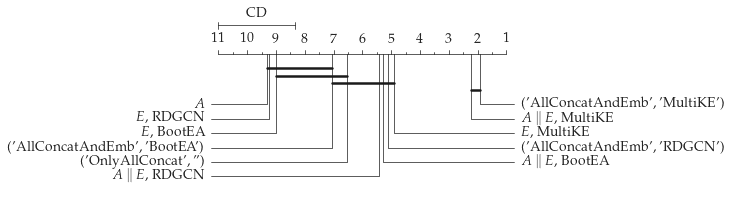

In [15]:
from autorank import autorank, plot_stats, create_report, latex_table
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
#wanted = new_rich_df.append(rich_df).pivot_table(index=["ds_size","dataset"],columns=["vector_name","embed_model"],values="fm").round(3)
wanted = new_rich_df.append(rich_df).pivot_table(index=["ds_size","model_name","dataset"],columns=["vector_name","embed_model"],values="fm").round(3)
tmp = wanted["OnlyAllConcat"].mean(axis=1).round(3)
wanted.drop(columns=["OnlyAllConcat"],inplace=True)
wanted["OnlyAllConcat"] = tmp
#wanted.columns = [c for c in wanted.columns]
result = autorank(wanted, alpha=0.05, verbose=False)
print(result)
plt.tight_layout()
ax = cd_diagram(result,True,None,width=6)
plt.savefig("/tmp/rich_cd.pdf",bbox_inches="tight")
wanted

RankResult(rankdf=
                              meanrank  median        mad ci_lower ci_upper  \
vector_name     embed_model                                                   
SimAndEmb       MultiKE       2.535714   0.996  0.0014826    0.972    0.997   
OnlySim                       2.785714   0.994  0.0051891    0.891    0.998   
SimAndEmb       RDGCN         3.535714   0.995  0.0014826    0.964    0.997   
                BootEA        3.821429   0.995  0.0022239    0.953    0.997   
OnlyAllConcat                 4.535714  0.9785  0.0237216    0.808    0.998   
AllConcatAndEmb MultiKE       5.142857   0.982   0.022239     0.76    0.997   
                BootEA        6.785714    0.97  0.0355824    0.751    0.997   
                RDGCN         6.857143  0.9675  0.0407715    0.768    0.997   
OnlyEmb         MultiKE       9.785714  0.6715   0.227579    0.383    0.913   
                BootEA       10.035714   0.647   0.113419    0.562    0.874   
                RDGCN        10.1

vector_name              AllConcatAndEmb                OnlyEmb          \
embed_model                       BootEA MultiKE  RDGCN  BootEA MultiKE   
model_name dataset                                                        
MLP        abt-buy                 0.885   0.958  0.925   0.623   0.383   
           amazon-google           0.751   0.789  0.784   0.631   0.571   
           dblp-acm                0.995   0.997  0.995   0.579   0.617   
           dblp-scholar            0.993   0.994  0.995   0.562   0.537   
           imdb-tmdb               0.967   0.988  0.969   0.874   0.911   
           imdb-tvdb               0.938   0.973  0.940   0.821   0.873   
           tmdb-tvdb               0.973   0.983  0.966   0.874   0.871   
RF         abt-buy                 0.952   0.952  0.920   0.648   0.655   
           amazon-google           0.798   0.760  0.768   0.646   0.645   
           dblp-acm                0.997   0.997  0.997   0.614   0.688   
           dblp-scholar            0.997   0.997  0.996   0.588   0.576   
           imdb-tmdb               0.977   0.984  0.975   0.859   0.913   
           imdb-tvdb               0.960   0.967  0.953   0.786   0.844   
           tmdb-tvdb               0.977   0.981  0.977   0.844   0.877   

vector_name                     OnlySim SimAndEmb                OnlyAllConcat  
embed_model               RDGCN            BootEA MultiKE  RDGCN                
model_name dataset                                                              
MLP        abt-buy        0.650   0.977     0.961   0.972  0.964         0.968  
           amazon-google  0.638   0.985     0.953   0.976  0.965         0.808  
           dblp-acm       0.559   0.997     0.995   0.997  0.995         0.997  
           dblp-scholar   0.547   0.997     0.993   0.994  0.995         0.997  
           imdb-tmdb      0.874   0.993     0.995   0.997  0.995         0.979  
           imdb-tvdb      0.807   0.968     0.996   0.997  0.994         0.965  
           tmdb-tvdb      0.857   0.891     0.996   0.996  0.994         0.981  
RF         abt-buy        0.661   0.977     0.973   0.972  0.973         0.966  
           amazon-google  0.665   0.982     0.978   0.978  0.975         0.817  
           dblp-acm       0.598   0.997     0.997   0.997  0.997         0.997  
           dblp-scholar   0.571   0.998     0.997   0.997  0.997         0.998  
           imdb-tmdb      0.873   0.995     0.995   0.996  0.995         0.980  
           imdb-tvdb      0.792   0.996     0.995   0.996  0.996         0.960  
           tmdb-tvdb      0.831   0.995     0.995   0.996  0.995         0.978

<Figure size 432x288 with 0 Axes>

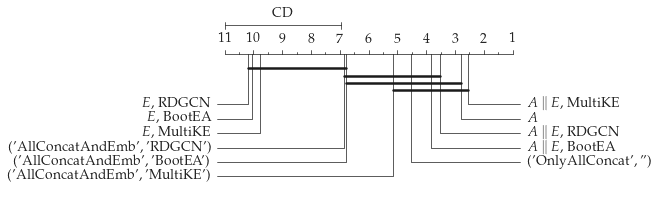

In [16]:
from autorank import autorank, plot_stats, create_report, latex_table
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
#wanted = new_rich_df.append(rich_df).pivot_table(index=["ds_size","dataset"],columns=["vector_name","embed_model"],values="fm").round(3)
wanted = new_shallow_df.append(shallow_df).pivot_table(index=["model_name","dataset"],columns=["vector_name","embed_model"],values="fm").round(3)
tmp = wanted["OnlyAllConcat"].mean(axis=1).round(3)
wanted.drop(columns=["OnlyAllConcat"],inplace=True)
wanted["OnlyAllConcat"] = tmp
#wanted.columns = [c for c in wanted.columns]
result = autorank(wanted, alpha=0.05, verbose=False)
print(result)
plt.tight_layout()
ax = cd_diagram(result,True,None,width=6)
plt.savefig("/tmp/shallow_cd.pdf",bbox_inches="tight")
wanted